In [1]:
#The Euler method for functional fractional Differential equations

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial
from numpy import *
from scipy.linalg import norm
import time

In [2]:
def initFun(s):
    """This function calculates initial function and is used to fulfill
    the first (presely, zero) time layer in the grid solution aray
    """
    # y(0) = 1
    res = s ** 5 + 3 * s ** 4 - 2 * s ** 3
    return res

In [3]:
def exactSolution(t):
    """This function calculates the exact solution,
    it is used to estimate the error
    """
    res = t ** 5 + 3 * t ** 4 - 2 * t ** 3
    return res

In [4]:
# Coefficient of the Adams'method: a_{j, i + 1}

def a_k_j(n,k, alfa):
    if k == n+1:
        return 1
    elif k == 0:
        return n**(alfa + 1) - (n - alfa)*(n + 1)**(alfa)
    else:
        return (n - k + 2)**(alfa + 1) + (n - k)**(alfa + 1) - 2*(n - k +1)**(alfa + 1)

In [5]:
def b_k_j(n,k, alfa):
    return (n - k + 1) ** alfa - (n - k) ** alfa

In [6]:
def kernalFun(s):
    return 1

In [7]:
def Fun(t, y, y_delaed, tau, alfa):
    res = gamma(6) * (t ** (5 - alfa)) / gamma(6 - alfa) + \
          3 * gamma(5) * (t ** (4 - alfa)) / gamma(5 - alfa) - \
          2 * gamma(4) * (t ** (3 - alfa)) / gamma(4 - alfa) + (t ** 5 + 3 * t ** 4 - 2 * t ** 3) ** 2 - \
          (1/6)*(t**6 - (t - tau)**6) - (3/5)*(t**5 - (t - tau)**5) + (1/2)*(t**4 - (t - tau)**4) + y_delaed - y ** 2
    return res

In [8]:
def tau(t):
    return (0.02)*np.exp(-t)

In [9]:
def moo(t,tStep, dellta):
    return int((0.02)*np.exp(-t)/(tStep))

Time domain [0.000000; 2.000000]
Number of subsegments in Time 20.000000
Time step 0.100000
0.01503133773803711
Error norm = 5.957040E-02


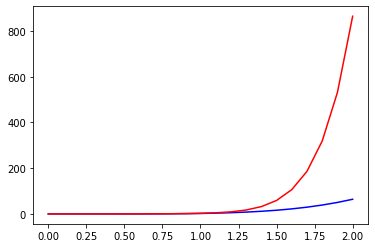

In [81]:
alfa = 0.9

tInit = 0  # tInit - initial time
tFinal = 2  # tFinal - final time
numberOfSegm_t = 20  # numSeg - number of subsegments in segment [tInint, tFinal]
epsNewton = 10 ** (-4)
tau = 0.5
y0 = 0

dellta = 0

print("Time domain [%f; %f]" % (tInit, tFinal))
print("Number of subsegments in Time %f" % numberOfSegm_t)
tStep = (tFinal - tInit) / numberOfSegm_t
timeGrid = linspace(tInit, tFinal, numberOfSegm_t + 1)
print("Time step %f" % tStep)
m = int(tau / tStep)
y = zeros(numberOfSegm_t + 1)
y_n = zeros(numberOfSegm_t + 1)
y_e = zeros(numberOfSegm_t + 1)
FiInvariant = zeros(numberOfSegm_t + 1)


y_n[0] = initFun(tInit)

startTime = time.time()
for i in range(numberOfSegm_t - 1, -1, -1):
    converged = False
    y_delayed = 0
    # Extrapolation and calculation of functional delay
    if i == 0:
        # Extrapolation by the prehistory
        uExtrap = 1.5 * y_n[0] - 0.5 * initFun(-tStep)
        if tau < tStep:
            uDelFin = y_n[0] + (tStep - tau) * (y_n[0] - initFun(-tStep)) / tStep
            tDelFin = tStep - tau  # time Delay Finish
        else:
            uDelFin = y_n[0]
            tDelFin = tStep
    else:
        # Extrapolation by the grid
        uExtrap = 1.5 * y_n[i] - 0.5 * y_n[i - 1]
        if tau < tStep:
            uDelFin = y_n[i] + (tStep - tau) * (
                    y_n[i] - y_n[i - 1]) / tStep
            tDelFin = tStep - tau  # time Delay Finish
        else:
            uDelFin = y_n[i]
            tDelFin = tStep
    y_delayed += (kernalFun(0) * uExtrap + kernalFun(-tDelFin) * uDelFin) * tDelFin
    #FiInvariant1[i] = Fun(timeGrid[i], uExtrap, y_delayed, tau, alfa)

    # calculation of functional delay inteher tSteps
    sBuf = 0
    # in the grid
    for q in range(0, min(i, m)):
        sBuf += kernalFun(-tStep - q * tStep) * (y_n[i - q]) + kernalFun(
            -tStep - (q + 1) * tStep) * (y_n[i - q - 1])
    # in the prehistory
    for q in range(min(i, m), m):
        sBuf += kernalFun(-tStep - q * tStep) * (
            initFun((i - q) * tStep)) + kernalFun(-tStep - (q + 1) * tStep) * (
            initFun((i - q - 1) * tStep))
    y_delayed += sBuf * tStep

    # calculation of functional delay in the "tail"
    if i - m > 0:
        segPart = tau / tStep - m
        
        uTail = y_n[i - m] * (1 - segPart) + y_n[i - m - 1] * segPart
        y_delayed += (kernalFun(-tStep - m * tStep) * (
            y_n[i - m]) + kernalFun(-tau) * uTail) * (
                              tau * tStep - m * tStep)
    else:
        uTail = initFun(i * tStep - tau)
        y_delayed += (kernalFun(-tStep - m * tStep) * (
            initFun((i - m) * tStep)) + kernalFun(-tau) * uTail) * (
                              tau * tStep - m * tStep)
    FiInvariant[i] = Fun(timeGrid[i],y[i], y_delayed, tau, alfa)
    
    r = 0
    while not converged:
        r += 1
        #Corrector
        y[i + 1] = y0 + (tStep ** alfa) * sum(
            [(1 / (gamma(alfa + 2))) * ( a_k_j(i,j, alfa)) * (
                FiInvariant[j]) for j in range(0, i + 1)]) + ((tStep ** alfa) / (gamma(alfa + 1)))*Fun(timeGrid[i+1], uExtrap , y_delayed, tau, alfa)
        
        converged = np.abs(y - y_n).max() < epsNewton or r >= 100

        y_n = copy(y)
        # Update y_n before next step
    y_n, y = y, y_n
    y_e[i+1] = exactSolution(timeGrid[i+1])
    diff = abs(y[i+1] - y_e[i+1]).max()
              
endTime = time.time()
print(endTime - startTime)
print("Error norm = %E" % diff)
plt.plot(timeGrid, y_e, 'blue')
plt.plot(timeGrid, y, 'r')
plt.show()

In [11]:
# Adams method for functional fractional differential equations

import math

Time domain [0.000000; 2.000000]
Number of subsegments in Time 80.000000
Time step 0.025000
0.09762167930603027
Error norm = 5.298640E-02


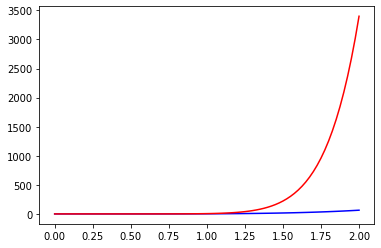

In [15]:
alfa = 0.1
tInit = 0.  # tInit - initial time
tFinal = 2.  # tFinal - final time
numberOfSegm_t = 80  # numSeg - number of subsegments in segment [tInint, tFinal]
epsNewton = 10 ** (-4)
tau = 0.5
y0 = 0

print("Time domain [%f; %f]" % (tInit, tFinal))
print("Number of subsegments in Time %f" % numberOfSegm_t)
tStep = (tFinal - tInit) / numberOfSegm_t
timeGrid = linspace(tInit, tFinal, numberOfSegm_t + 1)
print("Time step %f" % tStep)
m = int(tau / tStep)
y = zeros(numberOfSegm_t + 1)
y_n = zeros(numberOfSegm_t + 1)
y_e = zeros(numberOfSegm_t + 1)
FiInvariant = zeros(numberOfSegm_t + 1)


y_n[0] = initFun(tInit)

startTime = time.time()
for i in range(numberOfSegm_t - 1, -1, -1):
    converged = False
    y_delayed = 0
    y_delayed_1 = 0
    # Extrapolation and calculation of functional delay
    if i == 0:
        # Extrapolation by the prehistory
        uExtrap = 1.5 * y_n[0] - 0.5 * initFun(-tStep)
        if tau < tStep:
            uDelFin = y_n[0] + (tStep - tau) * (y_n[0] - initFun(-tStep)) / tStep
            tDelFin = tStep - tau  # time Delay Finish
        else:
            uDelFin = y_n[0]
            tDelFin = tStep
    else:
        # Extrapolation by the grid
        uExtrap = 1.5 * y_n[i] - 0.5 * y_n[i - 1]
        if tau < tStep:
            uDelFin = y_n[i] + (tStep - tau) * (
                    y_n[i] - y_n[i - 1]) / tStep
            tDelFin = tStep - tau  # time Delay Finish
        else:
            uDelFin = y_n[i]
            tDelFin = tStep
    y_delayed_1 += (kernalFun(0) * uExtrap + kernalFun(-tDelFin) * uDelFin) * tDelFin
    #FiInvariant1[i] = Fun(timeGrid[i], uExtrap, y_delayed, tau, alfa)

    # calculation of functional delay inteher tSteps
    sBuf = 0
    # in the grid
    for q in range(0, min(i, m)):
        sBuf += kernalFun(-tStep - q * tStep) * (y_n[i - q]) + kernalFun(
            -tStep - (q + 1) * tStep) * (y_n[i - q - 1])
    # in the prehistory
    for q in range(min(i, m), m):
        sBuf += kernalFun(-tStep - q * tStep) * (
            initFun((i - q) * tStep)) + kernalFun(-tStep - (q + 1) * tStep) * (
            initFun((i - q - 1) * tStep))
    y_delayed += sBuf * tStep

    # calculation of functional delay in the "tail"
    if i - m > 0:
        segPart = tau / tStep - m
        
        uTail = y_n[i - m] * (1 - segPart) + y_n[i - m - 1] * segPart
        y_delayed += (kernalFun(-tStep - m * tStep) * (
            y_n[i - m]) + kernalFun(-tau) * uTail) * (
                              tau * tStep - m * tStep)
    else:
        uTail = initFun(i * tStep - tau)
        y_delayed += (kernalFun(-tStep - m * tStep) * (
            initFun((i - m) * tStep)) + kernalFun(-tau) * uTail) * (
                              tau * tStep - m * tStep)
    FiInvariant[i] = Fun(timeGrid[i],y[i], y_delayed, tau, alfa)
    

    r = 0
    while not converged:
        r += 1
           
        #Corrector
        y[i + 1] = y0 + (tStep ** alfa) * sum(
            [(1 / (gamma(alfa + 1))) * ( a_k_j(i,j, alfa)) * (
                FiInvariant[j]) for j in range(0, i + 1)]) + ((tStep ** alfa) / (gamma(alfa + 1)))*Fun(timeGrid[i+1], uExtrap , y_delayed_1, tau, alfa)
        
        converged = np.abs(y - y_n).max() < epsNewton or r >= 100

        y_n = copy(y)
        # Update y_n before next step
    y_n, y = y, y_n
    y_e[i+1] = exactSolution(timeGrid[i+1])
    diff = abs(y[i+1] - y_e[i+1]).max()
              
endTime = time.time()
print(endTime - startTime)
print("Error norm = %E" % diff)
plt.plot(timeGrid, y_e, 'blue')
plt.plot(timeGrid, y, 'r')
plt.show()